#**Three Categories**

## Setup

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efbf0fd3a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7efbf0fd3a60>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError    : self._shutdown_workers()can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efbf0fd3a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.

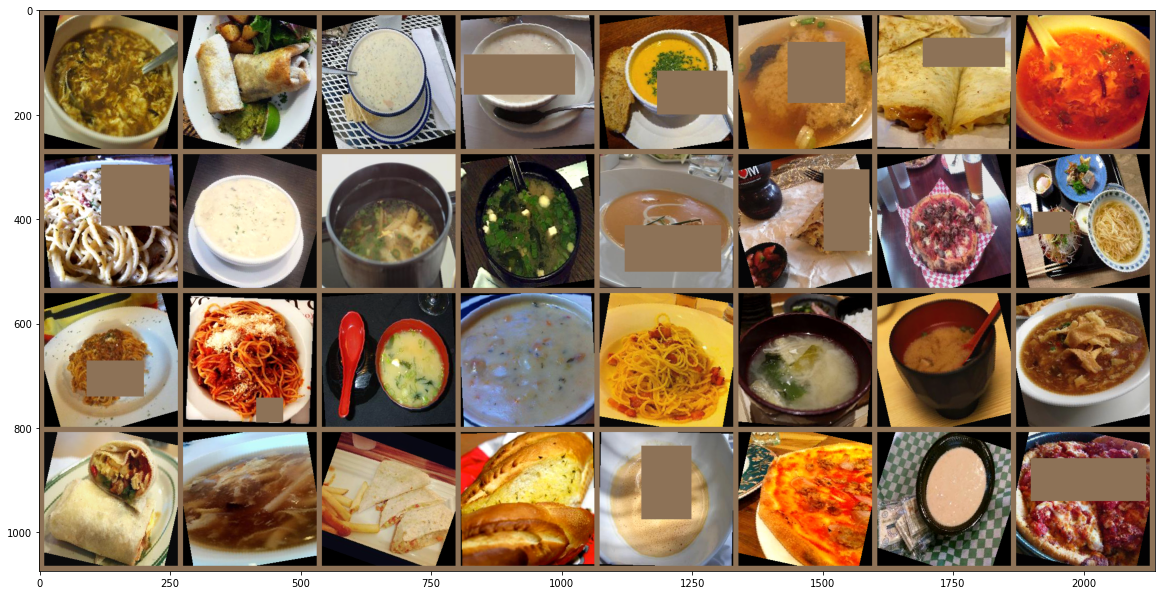

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets


ROOT_PATH = './drive/MyDrive/comp6721-project/datasets/dataset-3/'
training_path = f'{ROOT_PATH}/train'
validation_path = f'{ROOT_PATH}/val'
evaluation_path = f'{ROOT_PATH}/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
image_size = 256
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
num_classes = 3

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

# Model
model = models.resnet18(pretrained=False)
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, num_classes, device)
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

# Dataset
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

# Image samples
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Training

In [ ]:
# Training
%%time

num_epochs = 15
losses = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item()))


Epoch [ 1/15], Step [ 50/ 74], Loss: 0.9978
Epoch [ 2/15], Step [ 50/ 74], Loss: 0.7931
Epoch [ 3/15], Step [ 50/ 74], Loss: 0.7444
Epoch [ 4/15], Step [ 50/ 74], Loss: 0.5337
Epoch [ 5/15], Step [ 50/ 74], Loss: 0.6408
Epoch [ 6/15], Step [ 50/ 74], Loss: 0.5340
Epoch [ 7/15], Step [ 50/ 74], Loss: 0.6309
Epoch [ 8/15], Step [ 50/ 74], Loss: 0.5039
Epoch [ 9/15], Step [ 50/ 74], Loss: 0.4585
Epoch [10/15], Step [ 50/ 74], Loss: 0.5066
Epoch [11/15], Step [ 50/ 74], Loss: 0.3214
Epoch [12/15], Step [ 50/ 74], Loss: 0.5187
Epoch [13/15], Step [ 50/ 74], Loss: 0.4509
Epoch [14/15], Step [ 50/ 74], Loss: 0.5105
Epoch [15/15], Step [ 50/ 74], Loss: 0.5585
CPU times: user 1min, sys: 9.25 s, total: 1min 10s
Wall time: 4min 18s


## Valuation

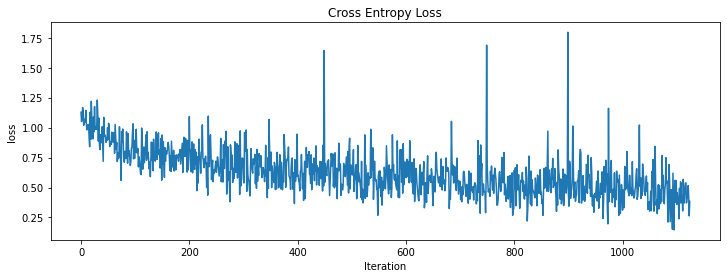

Train accuracy: 77.91
Test accuracy: 75.28
Confusion Matrix:
[[ 74   1  25]
 [ 25  11   3]
 [ 12   1 119]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       100
           1       0.85      0.28      0.42        39
           2       0.81      0.90      0.85       132

    accuracy                           0.75       271
   macro avg       0.77      0.64      0.66       271
weighted avg       0.76      0.75      0.74       271



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)